$$ 
\frac{\partial A}{\partial t} + c(x) \frac{\partial A}{\partial x} + \alpha(x) A \frac{\partial A}{\partial x} +\beta(x) \frac{\partial^3 A}{\partial x^3}
+ \frac{c(x)}{2Q(x)}\frac{\partial Q}{\partial x}A\ = 0
$$

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from iwaves.kdv.vkdv import  vKdV as KdV
import matplotlib
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
import cmocean
import sys
import metpy.calc as mpcalc
from scipy import signal
import scipy as sp
# Animate the solution
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML
import ffmpeg
from gptide import stats as gpstats
from gptide import GPtideScipy
from functions import Cov

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
C:\Users\21924032\Anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\21924032\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\21924032\Anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this 

In [4]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [15, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

# Specify the horizontal domain and create a bathymetry section

We use an analytical profile of a smooth shelf break represented with a tanh function.

In [6]:
def depth_tanh(beta, x):
    """
    Hyperbolic tangent shelf break

    H - total depth
    h0 - shelf height
    x0 - shelf break x location
    lt - shelf break width
    """
    
    H, h0, x0, lt = beta

    return H-0.5*h0*(1+np.tanh((x-x0)/(0.5*lt)))

$$
H-0.5*h0*(1+tanh(\frac{x-x0}{0.5*lt}))
$$

<Figure size 1500x1000 with 0 Axes>

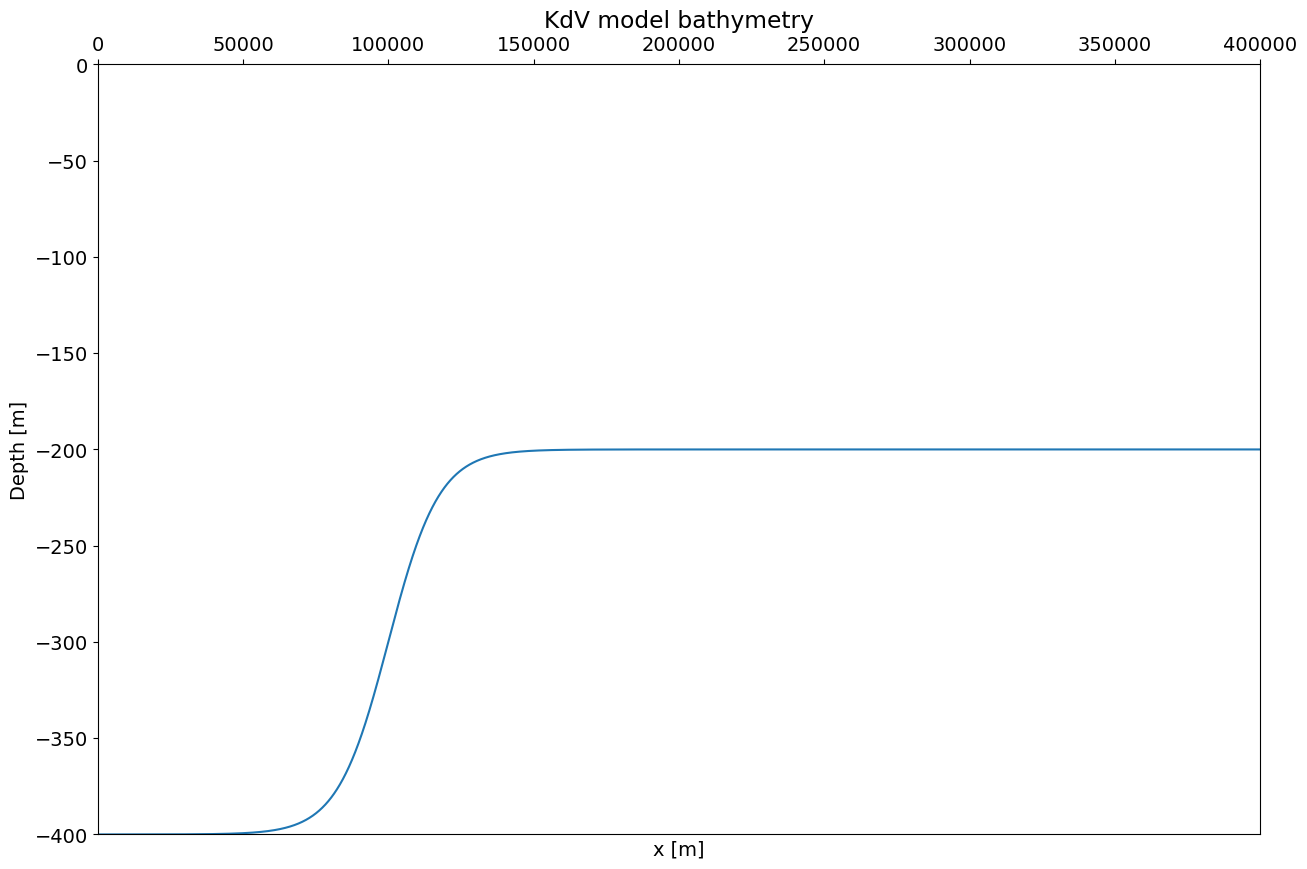

In [8]:
#bathy_params = [H, h0, x0, lt]  # See the depth_tanh function for the mean
bathy_params = [400,200,100e3,35e3] #set 3
N = 16000  # Number of grid points
dx = 25.  # horizontal grid spacing
# The horizontal domain
x = np.arange(0, N * dx, dx)
# The depth
h = depth_tanh(bathy_params, x)

plt.figure()
fig, ax = plt.subplots()
plt.plot(x, -h)  #negative bc depth
plt.title('KdV model bathymetry')
plt.ylabel('Depth [m]')
plt.xlabel('x [m]')
#plt.ylim(-H, 0)
plt.ylim(-bathy_params[0], 0)
plt.xlim(0, dx * N)
ax.xaxis.tick_top()

# Specify the vertical density profile

We use a <span class="mark">double hyperbolic tangent</span> to represent density profile. This is a good approximation for some regions of the upper ocean. See e.g.,

- Manderson, A, M. D. Rayson, E. Cripps, M. Girolami, J. P. Gosling, M. Hodkiewicz, N. L. Jones, G. N. Ivey, (2019) Uncertainty quantification of density and stratification estimates with implications for predicting ocean dynamics, *Journal of Atmospheric and Oceanic Technology*, [https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0200.1](https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0200.1)    <span class="mark">equation 11</span>
- Rayson, M. D., N. L. Jones and G. N. Ivey (2019), Observations of large amplitude mode-2 nonlinear internal waves on the Australian North West Shelf, *Journal of Physical Oceanography*, [https://doi.org/10.1175/JPO-D-18-0097.1](https://doi.org/10.1175/JPO-D-18-0097.1)





In [10]:
def rho_double_tanh(beta, z):
    """
    Double hyperbolic tangent density profile model
    """
#     return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])+ np.tanh((z+beta[4])/beta[5]))
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3]))-beta[6]*np.tanh((z+beta[4])/beta[5])

$$
\beta0-\beta1*(tanh(\frac{z+\beta2}{\beta3}+tanh(\frac{z+\beta4}{\beta5}))
$$

$$
\beta0-\beta1*tanh(\frac{z+\beta2}{\beta3})-\beta6*tanh(\frac{z+\beta4}{\beta5})
$$

In [13]:
#KIM400
obs = xr.open_dataset(r'C:\Users\21924032\GitHub\Yutao_PhD_codes\Aim2 Mode decomposition\notebooks\V3.0\PL3 Stacked data_mode_4 - density fit - double_tanh_new\stacked_LV3_KIM400-1307.nc')
obs_rho = obs['rhofit']

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<Figure size 600x600 with 0 Axes>

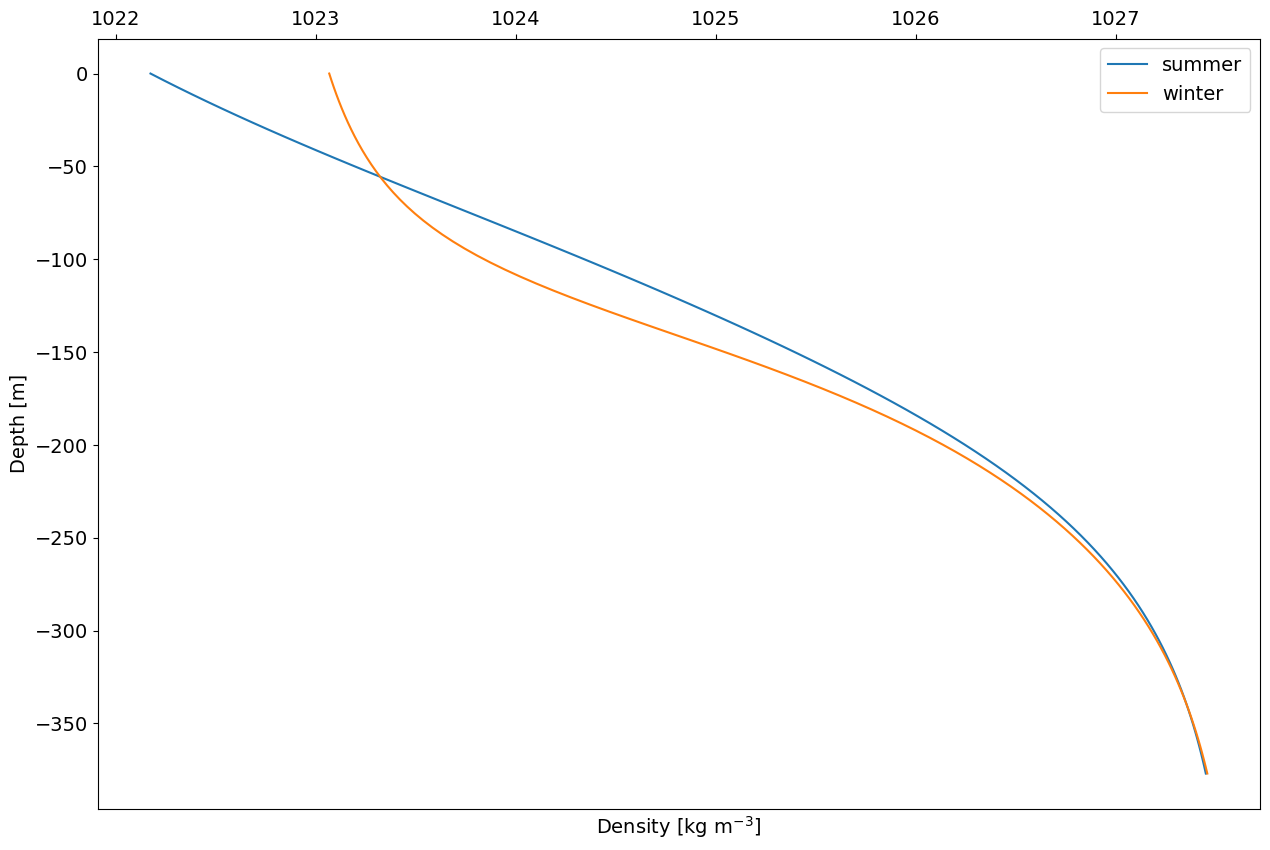

In [14]:
mean_rho_winter = obs_rho.sel(time=obs_rho['time.month'].isin([6, 7, 8])).mean(dim='time')
mean_rho_summer = obs_rho.sel(time=obs_rho['time.month'].isin([11, 12, 1])).mean(dim='time')

plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
plt.plot(mean_rho_summer,mean_rho_summer.z_interp,label ='summer')
plt.plot(mean_rho_winter, mean_rho_winter.z_interp,label='winter')
plt.ylabel('Depth [m]')
plt.xlabel('Density [kg m$^{-3}$]')
ax.xaxis.tick_top()
plt.legend()

In [15]:
# IMEX options (These are weights for the numerical time integration scheme)
imex={
        'MCN_AX2':(1/8., 3/8.),
        'AM2_AX2':(1/2., 1/2.),
        'AI2_AB3':(3/2., 5/6.),
        'BDF2_BX2':(0.,0.),
        'BDF2_BX2s':(0.,1/2.),
        'BI2_BC3':(1/3.,2/3.),
}

# Initialise the KdV model

This requires the density profile and bathymetric section plus a few other model inputs. This does not solve the equation; it only calculates the input parameters e.g. nonlinearity, linear phase speed.

In [185]:
dt = 40. #second
mode = 0 # Mode=0 corresponds to mode-1 waves
imexscheme = 'AM2_AX2'
c_im = imex[imexscheme][0]
b_ex = imex[imexscheme][1]

kdvargs = dict(
   N=N,
   dx=dx,
   dt=dt,
   spongedist = 5e3,
   spongetime = 360.,
   Nsubset = 10,
   nonhydrostatic=1.,
   nonlinear=1.,
   c_im=c_im,
   b_ex=b_ex,
   verbose=True,
)

## Initialise the class
rhoz = mean_rho_winter
z = mean_rho_winter.z_interp
mykdv_winter = KdV(rhoz, z, h, x, mode, **kdvargs)

rhoz = mean_rho_summer
z = mean_rho_summer.z_interp
mykdv_summer = KdV(rhoz, z, h, x, mode, **kdvargs)

Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...
Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...


## Inspect the KdV model parameters

In [137]:
def Plot_KdV_model_parameter(mykdv):
    # Plot some of the environmental parameters as a function of distance
    plt.figure(figsize=(6,10))
    
    ax1=plt.subplot(411)
    ax1.plot(mykdv.x, mykdv.c)
    plt.ylabel('c [m s$^{-1}$]')
    ax1.set_xticklabels([])
    
    ax2=plt.subplot(412)
    ax2.plot(mykdv.x, mykdv.alpha)
    plt.ylabel(r'$\alpha$ [s$^{-1}$]')
    ax2.set_xticklabels([])
    
    ax3=plt.subplot(413)
    ax3.plot(mykdv.x, mykdv.beta)
    plt.ylabel(r'$\beta$ [m$^3$ s$^{-1}$]')
    ax3.set_xticklabels([])
    
    ax2=plt.subplot(414)
    ax2.plot(mykdv.x, 1/mykdv.Q)
    plt.ylabel(r'Linear amplification "Q"')

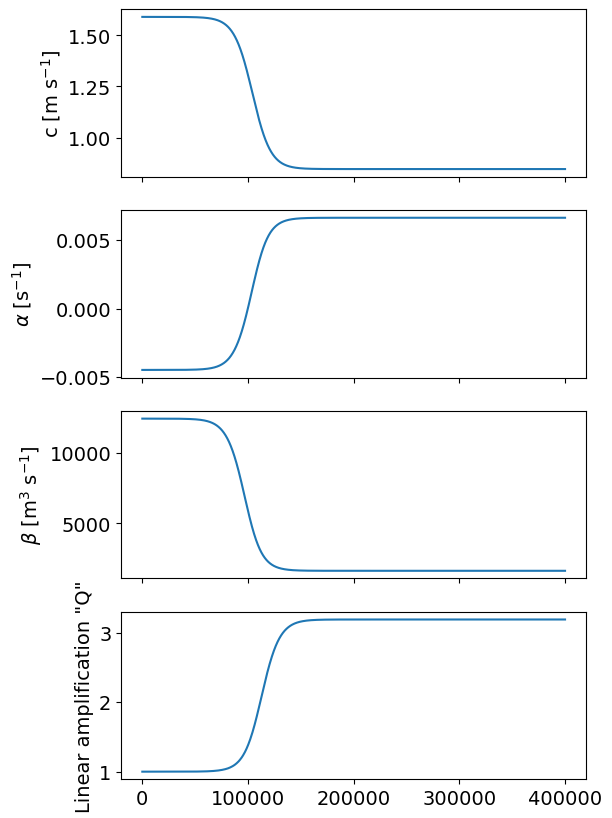

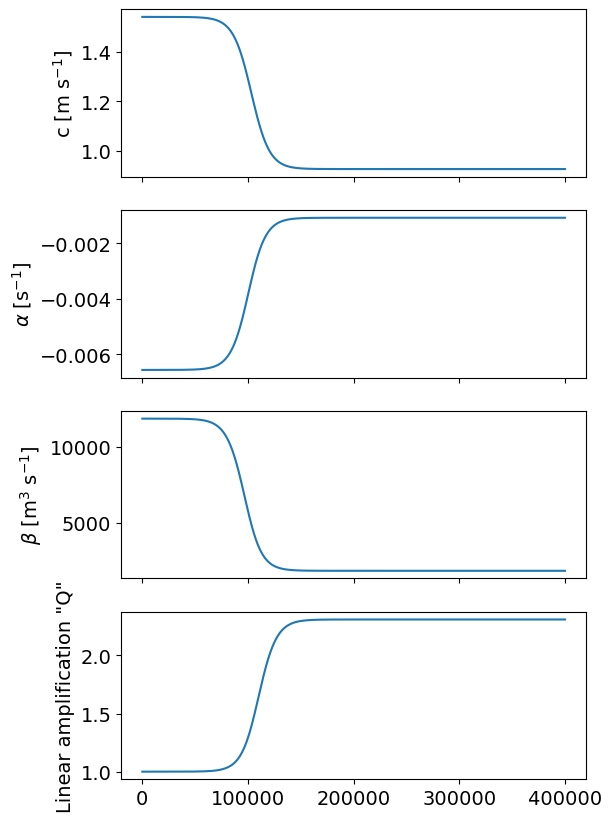

In [138]:
Plot_KdV_model_parameter(mykdv_winter)
Plot_KdV_model_parameter(mykdv_summer)

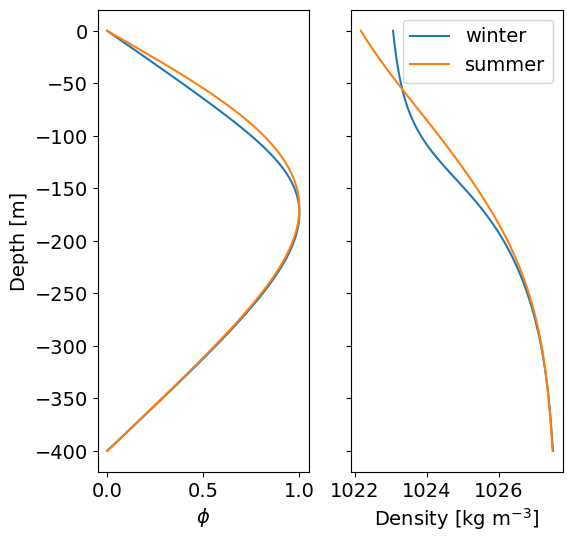

In [139]:
# Plot the density profile and vertical eigenfunction

plt.figure(figsize=(6,6))

ax1=plt.subplot(121)
ax1.plot(mykdv_winter.Phi[:,0],mykdv_winter.Z[:,0], label='winter')
ax1.plot(mykdv_summer.Phi[:,0],mykdv_winter.Z[:,0], label='summer')
plt.xlabel('$\phi$')

ax2=plt.subplot(122)
ax2.plot(mykdv_winter.rhoZ[:,0],mykdv_winter.Z[:,0], label='winter')
ax2.plot(mykdv_summer.rhoZ[:,0],mykdv_winter.Z[:,0], label='summer')
plt.xlabel('Density [kg m$^{-3}$]')
ax2.set_yticklabels([])
ax1.set_ylabel('Depth [m]')
plt.legend()

# Construct Boundary Condition

In [141]:
def M1L2(x,xpr,params):
    dx = np.abs(x-xpr)
    O1_freq = 0.93 #cpd
    K1_freq = 1 #cpd
    S2_freq = 1.93 #cpd
    M2_freq = 2 #cpd
    η_matern1,α_matern1,eta1,ℓ_exp1,eta2,ℓ_exp2, = params
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=(O1_freq+K1_freq)/2)
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=(S2_freq+M2_freq)/2)
    COV = matern1 + peak1 + peak2 
    return COV

In [142]:
parameter_set = pd.read_csv(r'C:\Users\21924032\GitHub\Yutao_PhD_codes\Aim1 1D Internal wave modeling\notebooks\1D internal tide temp model fit V1.6\Whole_model_fit_parameters_clean.csv')
KIM400_parameter_set = parameter_set[parameter_set['site']=='KIM400']
GP_parameter_set = KIM400_parameter_set[(KIM400_parameter_set['depth'] >= -170) & (KIM400_parameter_set['depth'] <= -150)].loc[:, 'η_c':'τ_D2'].mean()
GP_parameter_set

η_c     0.505594
2α_c    1.773039
η_D1    0.070323
τ_D1    4.722873
η_D2    0.304666
τ_D2    2.584490
dtype: float64

In [143]:
sample_interval_days = dt*3/86400  # seconds ~3min
sample_duration = 14 # seconds
sample_time = np.arange(0,sample_duration,sample_interval_days)
n_sample = 10
IW_profile = xr.DataArray(np.zeros((1,n_sample,len(sample_time))), dims=('depth','sample','time'))
#generate samples from the GP process
X = sample_time[:,None]
covparams = list(GP_parameter_set)
noise = 0
GP = GPtideScipy(X, X, noise, M1L2, covparams, mean_func=None)
sample = GP.prior(samples=n_sample).T
IW_profile[0] = sample  #random samples
#transfer to dataset and organising
IW_profile= IW_profile.to_dataset(name='Temperature')
IW_profile.coords['depth']=('depth',[120])
IW_profile.coords['time'] = ('time',sample_time*86400)
IW_profile.coords['sample'] = ('sample',np.arange(0,n_sample,1))  

C:\Users\21924032\GitHub\Yutao_PhD_codes\Aim1 1D Internal wave modeling\notebooks\1D internal tide temp model fit V1.6\functions\Cov.py:77: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [144]:
# #create a dataarry to contain the internal wave data varying with depth and time
# size = np.zeros((1,n_sample,len(time_length)))
# IW_profile = IW_profile.assign(max_displacement=(['depth','sample','time',],np.zeros((1,n_sample,len(time_length)))))
# max_ζ_at_point = max_ζ_from_u_single_point(ii,IW_profile,phi_profile,var_name)  
# IW_profile.max_displacement[0] = max_ζ_at_point

In [145]:
# #this function interpolate the loose points
# from scipy.interpolate import CubicSpline
# def BC_interp(sample_profile,x_interp,var_name):
#     x = sample_profile.time.values
#     n_sample = sample_profile.sample.values
#     sample_profile = sample_profile.assign_coords(time_2=x_interp)
#     sample_profile = sample_profile.assign(var_interp=(['depth','sample','time_2',],np.zeros((1,len(n_sample),len(x_interp)))))  
#     sample_profile = sample_profile.assign(displacement_interp=(['depth','sample','time_2',],np.zeros((1,len(n_sample),len(x_interp)))))
    
#     for i in n_sample:
#         y_var = sample_profile[var_name][0][i].values
#         y_displacement = sample_profile.max_displacement[0][i].values
#         cubic_interp_temp = CubicSpline(x, y_var)
#         cubic_interp_displacment = CubicSpline(x, y_displacement)
        
#         # Define points where you want to estimate values
#         # Interpolate the values
#         y_var_interp = cubic_interp_temp(x_interp)
#         y_displacement_interp = cubic_interp_displacment(x_interp)
    
#         sample_profile.var_interp[0][i] = y_var_interp
#         sample_profile.displacement_interp[0][i] = y_displacement_interp
#     return sample_profile

In [146]:
# KdV_BC_interval_days = 40/86400
# KdV_BC_duration = 30
# KdV_BC_time = np.arange(0,KdV_BC_duration,KdV_BC_interval_days)
# len(KdV_BC_time)

In [147]:
# M1L2_IW_depth_profile = BC_interp(M1L2_IW_depth_profile,KdV_BC_time,variable_name)
# M1L2_IW_depth_profile
# M1L2_IW_depth_profile.to_netcdf('M1L2_IW_depth_profile.nc')

# Specify a boundary condition

vole potential

Use a sine wave boundary condition

$$
    a0*sin(2\pi*f1*t-a1*sin(2\pi*f2*t))
$$
f1=M2

a1 controls the maximum variation on the phase

f2 controls how often the variation occur

In [150]:
def bcfunc(a0,period,t,a1=0,phase_frequency=0):
    omega = 2*np.pi/period
    theta = a1*np.pi*np.sin(2*np.pi*phase_frequency*t)
    return a0*np.sin(omega*t-theta)

In [408]:
t = sample_time*86400 #second
# Boundary condition parameters
a0 = 1.5
period = 0.5*86400  # 12 hours__semi-diurnal
Sine_BC = bcfunc(a0, period, t)  #no phase chagne
Sine_BC = xr.DataArray(Sine_BC,dims=('time'),coords={'time':t})

Text(0.5, 1.0, 'boundary condition')

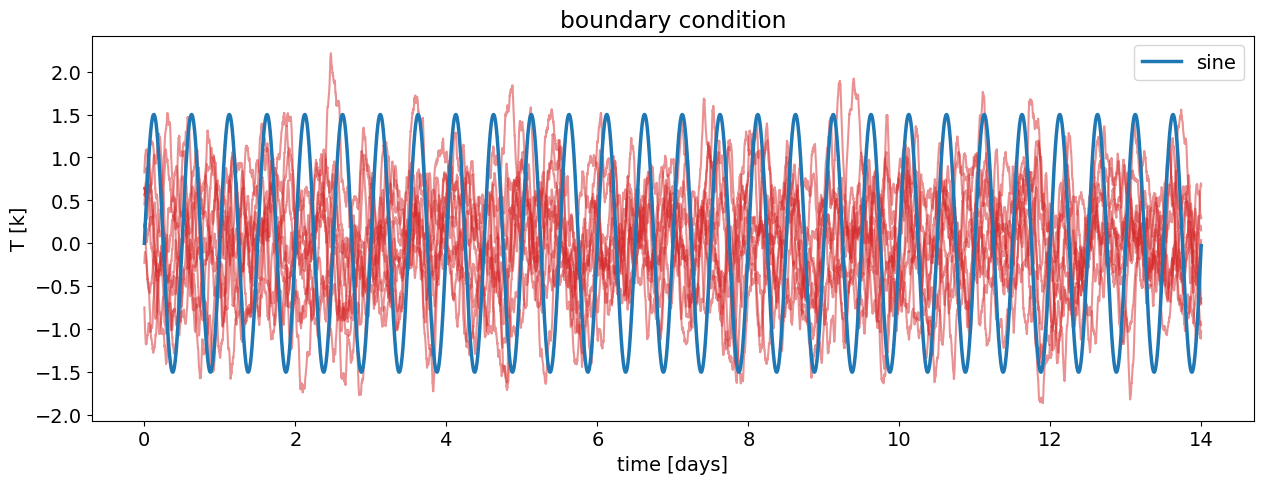

In [410]:
# Plot up the boundary function
plt.rcParams['figure.figsize'] = [15, 5]
for i in range(n_sample):
    plt.plot(IW_profile.time/86400,IW_profile.Temperature[0][i],alpha=0.5,color='tab:red',)
plt.plot(t/86400, Sine_BC, label="sine",linewidth=2.5)
plt.legend(loc="upper right")
plt.ylabel('T [k]')
plt.xlabel('time [days]')
plt.title("boundary condition")

# Run the model...

In [154]:
def bcfunc_GP(bc_gp,t):
    return bc_gp.sel(time=t,method='nearest').values

In [155]:
def kdv_calculator(mykdv,bcfunc,runtime,ntout):
    t=[]
    A=[]
    mykdv.t=0
    nsteps = int(runtime // mykdv.dt)
    for ii in range(nsteps):
        if ii%ntout==0:
            # Store snapshots of the solution every "ntout" steps
            t.append(mykdv.t)
            A.append(mykdv.B_n_p1*1) # the solution is stored as the "B_n_p1" anan
        if mykdv.solve_step(bc_left = bcfunc_GP(bcfunc,mykdv.t))!= 0:
            print('Blowing up at step: %d'%ii)
            break
    t = np.array(t)
    A = np.array(A)
    return t,A

## Run for winter

In [329]:
#model setup
dt = 40.
mode = 0 # Mode=0 corresponds to mode-1 waves
imexscheme = 'AM2_AX2'
c_im = imex[imexscheme][0]
b_ex = imex[imexscheme][1]
kdvargs = dict(
   N=N,
   dx=dx,
   dt=dt,
   spongedist = 5e3,
   spongetime = 360.,
   Nsubset = 10,
   nonhydrostatic=1.,
   nonlinear=1.,
   c_im=c_im,
   b_ex=b_ex,
   verbose=True,
)


In [393]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def plot_amplitude_animation(time, amplitude, x, frame_step=1, save_path=None):
    # Check input dimensions
    if amplitude.shape[0] != len(time):
        raise ValueError("The number of rows in 'amplitude' must match the length of 'time'.")
    if amplitude.shape[1] != len(x):
        raise ValueError("The number of columns in 'amplitude' must match the length of 'x'.")
    
    # Convert time to days for text display
    time_days = time / (24 * 3600)  # Assuming time is in seconds
    
    # Create the figure and axis
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    fig_text = fig.text(0.8, 0.9, "", fontsize=10, ha="center")  # Text to display time
    
    # Initialize the plot
    def init():
        ax.set_xlim(np.min(x), np.max(x))
        ax.set_ylim(np.min(amplitude), np.max(amplitude))
        ax.set_xlabel("x")
        ax.set_ylabel("Amplitude")
        ax.set_title("Amplitude vs x over Time")
        return line, fig_text
    
    # Update the plot for each frame
    def update(frame):
        current_idx = frame * frame_step
        if current_idx >= len(time):
            current_idx = len(time) - 1
        line.set_data(x, amplitude[current_idx, :])
        ax.set_title('KdV output')
        fig_text.set_text(f"t = {time_days[current_idx]:.2f} days")
        return line, fig_text
    
    # Create the animation
    ani = FuncAnimation(fig, 
        update, 
        frames=range(0, len(time), frame_step), 
        init_func=init, 
        blit=False)
    
    # Save the animation if a save path is provided
    if save_path:
        ani.save(save_path, fps=30, writer="ffmpeg")
    
    # Show the animation
    plt.show()


### Sine_BC

In [412]:
rhoz = mean_rho_winter
z = mean_rho_winter.z_interp
mykdv_winter = KdV(rhoz, z, h, x, mode, **kdvargs)
ntout = 30 # Store snapshots of the solution every "ntout" steps
runtime = 14*86400 #14 days
t_Sine,A1_Sine = kdv_calculator(mykdv_winter,Sine_BC,runtime,ntout)

Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...


MovieWriter ffmpeg unavailable; using Pillow instead.


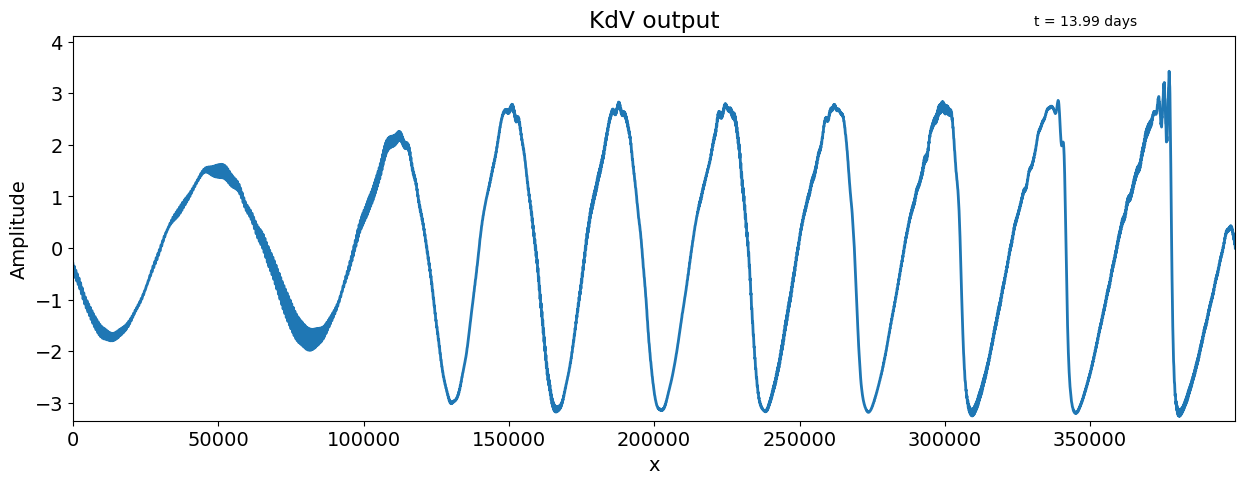

In [413]:
plot_amplitude_animation(t_Sine, A1_Sine, x, frame_step=2, save_path='KdV results_14_day_Sine_BC_Winter.gif')

### GP sample BC

In [415]:
rhoz = mean_rho_winter
z = mean_rho_winter.z_interp
mykdv_winter = KdV(rhoz, z, h, x, mode, **kdvargs)
runtime = 86400 * 14 
ntout = 4
t_GP,A1_GP = kdv_calculator(mykdv_winter,IW_profile.Temperature[0][0],runtime,ntout)

Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...


MovieWriter ffmpeg unavailable; using Pillow instead.


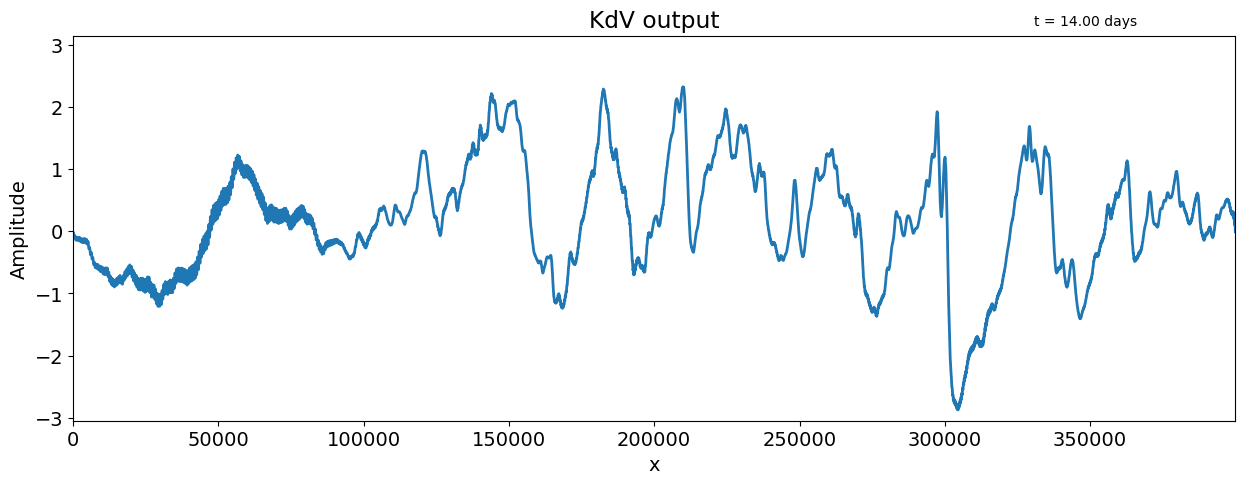

In [416]:
plot_amplitude_animation(t_GP, A1_GP, x, frame_step=2, save_path='KdV results_14_day_GP_BC_Winter.gif')

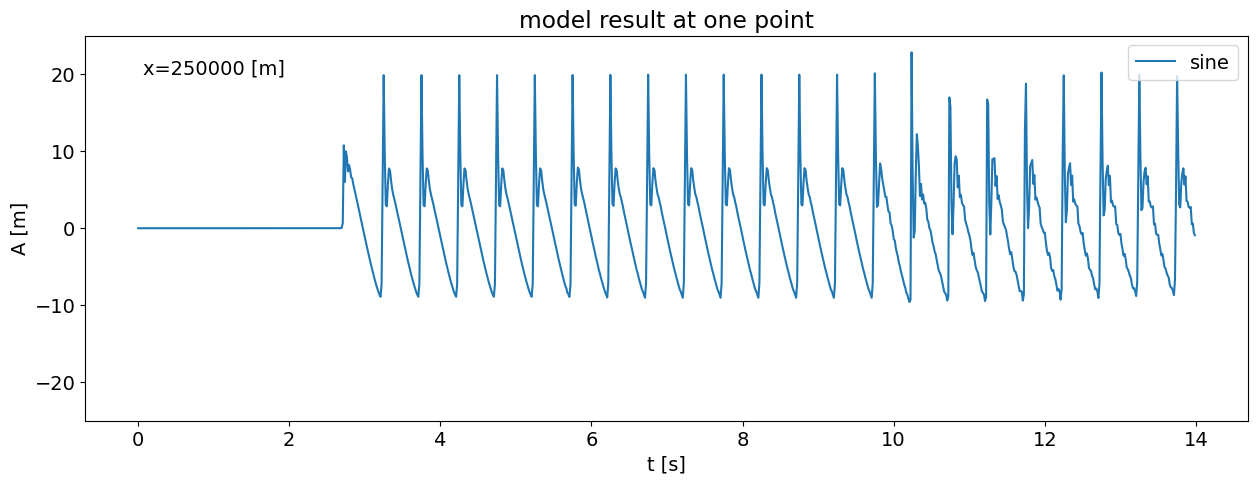

In [344]:
distance = 250000  #need to be 25n
xstep = int(distance // dx-1)

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(111)
xx1 = ax.plot(t_Sine/86400,A1_Sine[:, xstep],label="sine")
# xx2 = ax.plot(t_GP/86400,A1_GP[:, xstep],label="GP")

#plt.xlim(t1[0], t1[-1])
plt.legend(loc="upper right")
plt.ylabel('A [m]')
plt.xlabel('t [s]')
plt.title('model result at one point')
txt = plt.text(0.05, 0.9, "x={} [m]".format(distance), transform=ax.transAxes)
plt.ylim(-25, 25)
plt.show()

## Run for Summer

In [ ]:
rhoz = mean_rho_winter
z = mean_rho_winter.z_interp
mykdv_winter = KdV(rhoz, z, h, x, mode, **kdvargs)
runtime = 86400 * 5 # 8 days
ntout = 4
t1,A1 = kdv_calculator(mykdv_winter,Sine,runtime,ntout)

# Investigating how the energy transfer over distance

# Investigating how different phase will impact the energy transformation

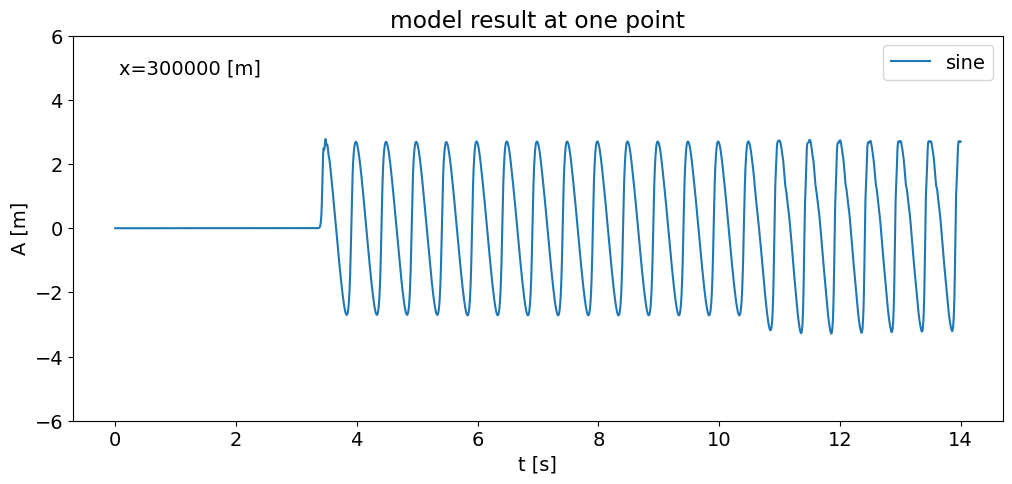

In [111]:
distance = 300000  #need to be 25n
xstep = int(distance // dx-1)

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
xx1 = ax.plot(t_Sine_BC/86400,A1_Sine_BC[:, xstep],label="sine")
# xx2 = ax.plot(t2, A2[:, xstep],label="sine with MP 4days with a1=2")
# xx3 = ax.plot(t3, A3[:, xstep],label="sine with MP 4days with a1=0.2")

#plt.xlim(t1[0], t1[-1])
plt.legend(loc="upper right")
plt.ylabel('A [m]')
plt.xlabel('t [s]')
plt.title('model result at one point')
txt = plt.text(0.05, 0.9, "x={} [m]".format(distance), transform=ax.transAxes)
plt.ylim(-4 * a0, 4 * a0)
plt.show()

In [169]:
from scipy import signal as sg
def Periodogram(time, data):
    """
    input: time-series data
    output: periodogram
    """
    sampling_interval = (t1[1]-t1[0])/86400
    f_obs, Puu_obs = sg.periodogram(data, fs=1/sampling_interval,)
    return f_obs,Puu_obs/2 # devide by 2 !!

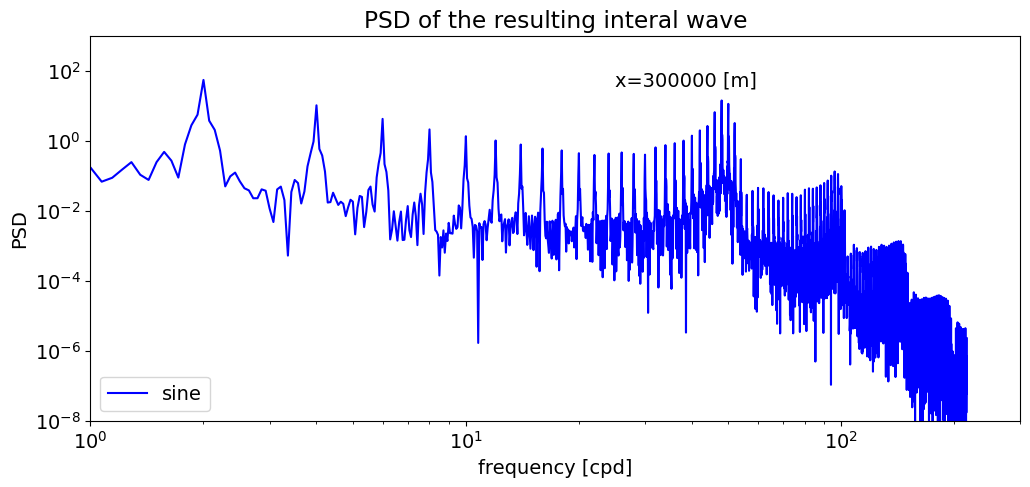

In [179]:
freq1, psd1 = Periodogram(t1, A1[:, xstep])
# freq2, psd2 = PSD(t2, A2[:, xstep])
# freq3, psd3 = PSD(t3, A3[:, xstep])


fig = plt.figure(figsize=(12, 5))
plt.plot(freq1, psd1, "b", label="sine")
# plt.plot(freq2, psd2, "r", label="sine with MP 4days with a1=2")
# plt.plot(freq3, psd3, "g", label="sine with MP 4days with a1=0.2")
plt.ylim(1e-8,1e3)
plt.xlim(1,3e2)
plt.yscale("log")
plt.xscale("log")
plt.ylabel('PSD')
plt.xlabel('frequency [cpd]')
plt.title("PSD of the resulting interal wave")
txt = plt.text(0.5, 0.9, "x={} [m]".format(distance), transform=ax.transAxes)

# xcoords = [coriolis_freq, buoyancy_freq, M2_freq, M4_freq, M6_freq, M8_freq]
# xcoords_label = ['coriolis_freq', 'buoyancy_freq', 'M2_freq', 'M4_freq', 'M6_freq','M8_freq']
# xcoords_color = ['orange', 'c', 'b', 'm', 'g', 'y']

# for i in range(len(xcoords)):
#     plt.axvline(x=xcoords[i],linestyle='--', color=xcoords_color[i], label=xcoords_label[i])

plt.legend(loc="lower left")
plt.show()

In [ ]:
f1, Pxx_den1 = PSD_welch(A1[:, xstep])
f2, Pxx_den2 = PSD_welch(A2[:, xstep])
f3, Pxx_den3 = PSD_welch(A3[:, xstep])


plt.plot(f1, Pxx_den1, "b", label="sine")
plt.plot(f2, Pxx_den2, "r", label="sine with MP 4days with a1=2")
plt.plot(f3, Pxx_den3, "g-", label="sine with MP 4days with a1=0.2")

plt.yscale("log")
plt.xscale("log")

plt.ylim([10e-2, 10e6])
plt.legend(loc="upper right")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

txt = plt.text(0.25, 1.9, "x={} [m]".format(distance), transform=ax.transAxes)
xcoords = [coriolis_freq, buoyancy_freq, M2_freq, M4_freq, M6_freq, M8_freq]
xcoords_label = ['coriolis_freq', 'buoyancy_freq', 'M2_freq', 'M4_freq', 'M6_freq','M8_freq']
xcoords_color = ['orange', 'c', 'b', 'm', 'g', 'y']

for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],linestyle='--', color=xcoords_color[i], label=xcoords_label[i])

plt.legend(loc="lower left")
plt.show()

In [ ]:
dt